# Verification experiment - NARMAX

I generate data according to a NARMAX model and recover parameters using both a FEM estimator and an RLS estimator. 

The estimators are validated with a simulation error experiment.

In [1]:
using Revise
using ProgressMeter
using LinearAlgebra
using JLD
using Plots
pyplot();

## Data generation

#### Experimental parameters

In [2]:
# # Polynomial degrees (t = true, m = model)
# deg_t = 3
# deg_m = 3;

In [3]:
# # True orders
# M1_t = 3
# M2_t = 3
# M3_t = 3
# M_t = M1_t + 1 + M2_t + M3_t

# # Model orders
# M1_m = 3
# M2_m = 3
# M3_m = 3
# M_m = M1_m + 1 + M2_m + M3_m

# # Number of coefficients
# N_t = M_t*deg_t + 1
# N_m = M_m*deg_m + 1;

In [4]:
# # True basis function
# PΨ = zeros(M_t,1); for d=1:deg_t; PΨ = hcat(d .*Matrix{Float64}(I,M_t,M_t), PΨ); end
# ψ(x::Array{Float64,1}) = [prod(x.^PΨ[:,k]) for k = 1:size(PΨ,2)];

# # Model basis function
# PΦ = zeros(M_m,1); for d=1:deg_m; PΦ = hcat(d .*Matrix{Float64}(I,M_m,M_m), PΦ); end
# ϕ(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)];

In [5]:
# # Parameters
# τ_true = 1e6
# θ_true = .5 .*(rand(N_t,) .- 0.5);
# θ_true[end] = 0.;

In [6]:
# # Length of transient period
# tt = 50

# # Length of observed signal
# ts = 200 + tt

# # Length of simulation horizon
# T = 1000 + ts;

#### Generate input

In [7]:
# include("fMultiSinGen.jl")

# # Parameters
# num_periods = 10
# points_period = 1000
# num_real = 1
# fMin = 0.0
# fMax = 100.0
# fs = 10 .* fMax
# uStd = 0.1

# # Input frequency and amplitude
# input, inputfreq = fMultiSinGen(points_period, 
#                                 num_periods, 
#                                 num_real, 
#                                 fMin=fMin, 
#                                 fMax=fMax, 
#                                 fs=fs, 
#                                 type_signal="odd", 
#                                 uStd=uStd);

# # Scale down
# # input /= 10.;

In [8]:
# plot(input, color="red", label="input")

In [9]:
# savefig("figures/NARMAX-generated-input_deg"*string(deg_t)*"_order"*string(M_t)*".png")

In [10]:
# ix_zoom = 100:300
# plot(ix_zoom, input[ix_zoom], color="red", label="input", xlabel="time (k)", ylabel="signal")

In [11]:
# savefig("figures/NARMAX-generated-input_deg"*string(deg_t)*"_order"*string(M_t)*"_zoom100-300.png")

#### Generate output

In [12]:
# # Observation array
# output = zeros(T,)
# errors = zeros(T,)

# for k = 1:T

#     # Generate noise
#     errors[k] = sqrt(inv(τ_true))*randn(1)[1]

#     # Output
#     if k < (maximum([M1_t, M2_t, M3_t])+1)
#         output[k] = input[k] + errors[k]
#     else
#         # Update history vectors
#         x_kmin1 = output[k-1:-1:k-M1_t]
#         z_kmin1 = input[k-1:-1:k-M2_t]
#         r_kmin1 = errors[k-1:-1:k-M3_t]

#         # Compute output
#         output[k] = θ_true'*ψ([x_kmin1; input[k]; z_kmin1; r_kmin1]) + errors[k]
#     end
# end

# # Y-Limits of output signal
# ylims = [minimum(output[tt:T]), maximum(output[tt:T])];

In [13]:
# plot(output[tt:T], color="black", label="output")

In [14]:
# savefig("figures/NARMAX-generated-output_deg"*string(deg_t)*"_order"*string(M_t)*".png")

In [15]:
# plot(input[tt:T], color="red", label="input")
# plot!(output[tt:T], color="black", label="output")

In [16]:
# savefig("figures/NARMAX-generated-input+output_deg"*string(deg_t)*"_order"*string(M_t)*".png")

In [17]:
# # Visualize signal
# zoom_t = 200:400
# p101 = plot(zoom_t, input[zoom_t], color="red", label="input", xlabel="time (k)", ylabel="", size=(600,220))
# plot!(zoom_t, output[zoom_t], color="black", label="output", legend=:topleft)

In [18]:
# savefig(p101, "figures/NARMAX-generated-input+output_deg"*string(deg_t)*"_order"*string(M_t)*"_zoom200-400.png")

In [19]:
# Load from Maarten's code
using MAT
mat_data = matread("input/synthNARMAX.mat")
input = [mat_data["dataSysTrain"]["u"]; mat_data["dataSysTest"]["u"]]
errors = [mat_data["dataSysTrain"]["e"]; mat_data["dataSysTest"]["e"]]
output = [mat_data["yTrain"]; mat_data["yTest"]]
tt = 10
ts = length(mat_data["yTrain"])
T = length(output);

M1_m = convert(Int64, mat_data["ToySystem"]["nb"])
M2_m = convert(Int64, mat_data["ToySystem"]["na"])
M3_m = convert(Int64, mat_data["ToySystem"]["ne"])
deg_m = convert(Int64, mat_data["ToySystem"]["nd"])

M_m = M1_m + 1 + M2_m + M3_m
N_m = M_m*deg_m + 1;

θ_true = mat_data["ToySystem"]["theta"]
τ_true = inv(mat_data["ToySystem"]["stde"].^2);

# Model basis function
PΦ = zeros(M_m,1); for d=1:deg_m; PΦ = hcat(d .*Matrix{Float64}(I,M_m,M_m), PΦ); end
ϕ(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)];

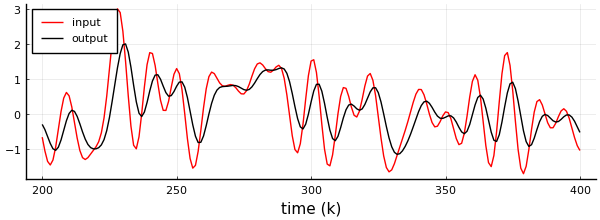

In [20]:
# Visualize signal
zoom_t = 200:400
p101 = plot(zoom_t, input[zoom_t], color="red", label="input", xlabel="time (k)", ylabel="", size=(600,220))
plot!(zoom_t, output[zoom_t], color="black", label="output", legend=:topleft)

In [21]:
RMS_KLS = mat_data["RMS_KLS"]

0.001567107310452663

## Model specification

In [22]:
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafeMeanCov
using NARMAX

In [23]:
graph = FactorGraph()

# Observed variables
@RV x_kmin1; placeholder(x_kmin1, :x_kmin1, dims=(M1_m,))
@RV z_kmin1; placeholder(z_kmin1, :z_kmin1, dims=(M2_m,))
@RV r_kmin1; placeholder(r_kmin1, :r_kmin1, dims=(M3_m,))
@RV u_k; placeholder(u_k, :u_k)

# Time-invariant parameters
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
@RV θ ~ GaussianMeanVariance(placeholder(:m_θ, dims=(N_m,)), placeholder(:v_θ, dims=(N_m, N_m)))

# Likel7ihood
@RV y_k ~ NAutoRegressiveMovingAverageX(θ, x_kmin1, u_k, z_kmin1, r_kmin1, τ, g=ϕ)
placeholder(y_k, :y_k)

# ForneyLab.draw(graph)

# Compile message passing procedure
q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
algorithm = messagePassingAlgorithm([θ; τ], q, free_energy=true)
source_code = algorithmSourceCode(algorithm, free_energy=true)
eval(Meta.parse(source_code));

## Inference

In [24]:
# Initialize priors
θ_k = (zeros(N_m,), 10. .*Matrix{Float64}(I,N_m,N_m))
τ_k = (1e6, 1e0)

# Initialize marginals
marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=θ_k[1], v=θ_k[2]),
                 :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_k[1], b=τ_k[2]))

# Number of iterations
num_iters = 5

# Preallocate free energy array
Fq = zeros(ts-tt+1,num_iters)

# Preallocate parameter arrays
params_θ = (zeros(ts-tt+1,N_m), zeros(ts-tt+1,N_m,N_m))
params_τ = (zeros(ts-tt+1,1), zeros(ts-tt+1,1))

# Keep track of residuals
predictions_FEM = (zeros(T,), zeros(T,))
residuals = zeros(T,)

@showprogress for (ii,k) in enumerate(tt:ts)
    
    # Update history vectors
    x_kmin1 = output[k-1:-1:k-M1_m]
    z_kmin1 = input[k-1:-1:k-M2_m]
    r_kmin1 = residuals[k-1:-1:k-M3_m]
    
    # Predictions
    ϕx = ϕ([x_kmin1; input[k]; z_kmin1; r_kmin1])
    predictions_FEM[1][k] = θ_k[1]'*ϕx
    predictions_FEM[2][k] = ϕx'*θ_k[2]'*ϕx + inv(τ_k[1]/τ_k[2])
    
    # Compute prediction error
    residuals[k] = output[k] - predictions_FEM[1][k]
    
    # Set data 
    data = Dict(:y_k => output[k],
                :u_k => input[k],
                :x_kmin1 => x_kmin1,
                :z_kmin1 => z_kmin1,
                :r_kmin1 => r_kmin1,
                :m_θ => θ_k[1],
                :v_θ => θ_k[2],
                :a_τ => τ_k[1],
                :b_τ => τ_k[2])
    
    # Iterate updates
    for n = 1:num_iters
        
        # Compute free energy
        Fq[ii,n] = freeEnergy(data,marginals)
        
        # Update parameters
        stepθ!(data, marginals)
        stepτ!(data, marginals)
        
    end 
    
    # Update params
    θ_k = (unsafeMean(marginals[:θ]), unsafeCov(marginals[:θ]))
    τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])
    
    # Store params
    params_θ[1][ii,:] = θ_k[1]
    params_θ[2][ii,:,:] = θ_k[2]
    params_τ[1][ii] = τ_k[1]
    params_τ[2][ii] = τ_k[2]
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10:58


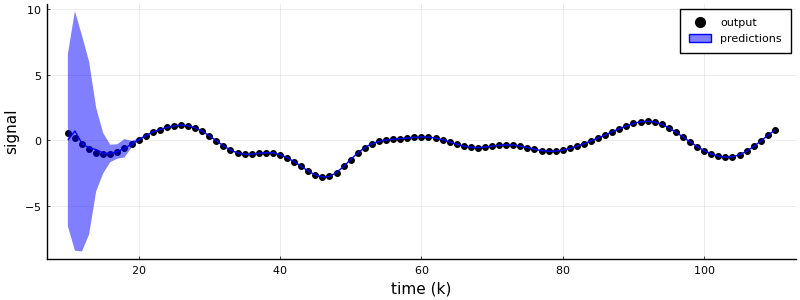

In [25]:
if (ts-tt) > 100
    scatter(tt:tt+100, output[tt:tt+100], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
    plot!(tt:tt+100, predictions_FEM[1][tt:tt+100], ribbon=[sqrt.(predictions_FEM[2][tt:tt+100]), sqrt.(predictions_FEM[2][tt:tt+100])], color="blue", label="predictions")
else
    scatter(tt:ts, output[tt:ts], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
    plot!(tt:ts, predictions_FEM[1][tt:ts], ribbon=[sqrt.(predictions_FEM[2][tt:ts]), sqrt.(predictions_FEM[2][tt:ts])], color="blue", label="predictions")
end

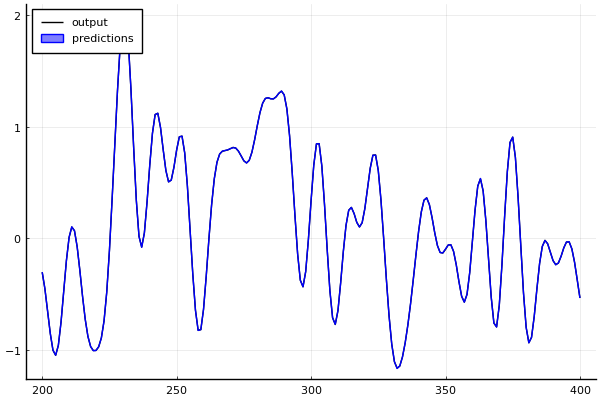

In [26]:
# Visualize signal
zoom_t = 200:400
p101 = plot(zoom_t, output[zoom_t], color="black", label="output", legend=:topleft)
plot!(zoom_t, predictions_FEM[1][zoom_t], ribbon=[sqrt.(predictions_FEM[2][zoom_t]), sqrt.(predictions_FEM[2][zoom_t])], color="blue", label="predictions")

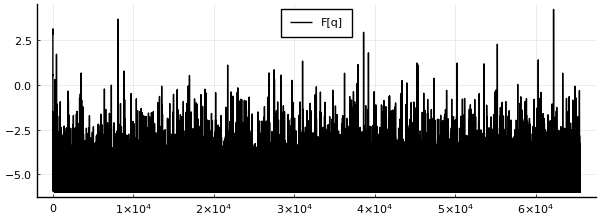

In [27]:
plot(Fq[:,end], color="black", label="F[q]", size=(600,220))

In [28]:
save("results/FE-NARMAX_FEM_M"*string(M_m)*"_degree"*string(deg_m)*"_S"*string(ts-tt)*".jld", "FE", Fq)

## Simulation

In [29]:
# Prepare array
simulations_FEM = (zeros(T,), zeros(T,))
simulations_FEM[1][1:ts] = output[1:ts]

@showprogress for k in ts:T
    
    # Update history vectors
    x_kmin1 = simulations_FEM[1][k-1:-1:k-M1_m]
    z_kmin1 = input[k-1:-1:k-M2_m]
    r_kmin1 = zeros(M3_m,)
    
    # Apply basis function
    ϕx = ϕ([x_kmin1; input[k]; z_kmin1; r_kmin1])
    
    # Predictions
    simulations_FEM[1][k] = θ_k[1]'*ϕx
    simulations_FEM[2][k] = ϕx'*θ_k[2]'*ϕx + inv(τ_k[1]/τ_k[2])
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


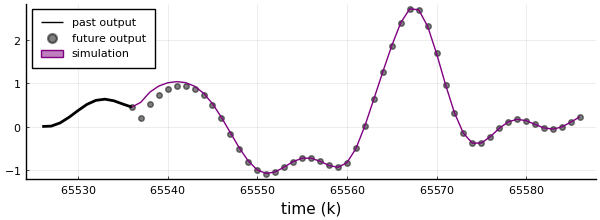

In [76]:
past = 10
viz_t = 50
p210 = plot(ts-past:ts, output[ts-past:ts], color="black", linewidth=2, label="past output", xlabel="time (k)", ylabel="", size=(600,220), legend=:topleft)
scatter!(ts:ts+viz_t, output[ts:ts+viz_t], color="black", label="future output", alpha=0.5, xlabel="time (k)")
plot!(ts:ts+viz_t, simulations_FEM[1][ts:ts+viz_t], ribbon=[sqrt.(simulations_FEM[2][ts:ts+viz_t]), sqrt.(simulations_FEM[2][ts:ts+viz_t])], color="purple", label="simulation")

In [77]:
savefig(p210, "figures/NARMAX-simulation_deg"*string(deg_m)*"_order"*string(M_m)*"_FEM_simfirst"*string(viz_t)*".png")

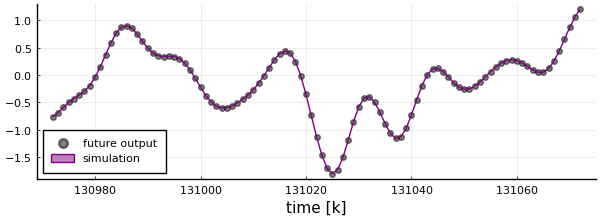

In [55]:
scatter(T-100:T, output[T-100:T], color="black", label="future output", alpha=0.5, xlabel="time [k]", size=(600,220))
plot!(T-100:T, simulations_FEM[1][T-100:T], ribbon=[sqrt.(simulations_FEM[2][T-100:T]), sqrt.(simulations_FEM[2][T-100:T])], color="purple", label="simulation")

In [56]:
savefig("figures/NARMAX-simulation_deg"*string(deg_m)*"_order"*string(M_m)*"_FEM_simlast100.png")

In [34]:
# # Full signal
# scatter(tt:T, output[tt:T], color="black", markersize=3, label="output", xlabel="time (k)", ylabel="signal", size=(800,300))
# plot!(tt:ts, predictions_FEM[1][tt:ts], ribbon=[sqrt.(predictions_FEM[2][tt:ts]), sqrt.(predictions_FEM[2][tt:ts])], color="blue", label="predictions")
# # plot!(ts:T, simulations_FEM[1][ts:T], ribbon=[sqrt.(simulations_FEM[2][ts:T]), sqrt.(simulations_FEM[2][ts:T])], color="purple", label="simulation")

In [35]:
# savefig("figures/NARMAX-fullsignal_deg"*string(deg_m)*"_order"*string(M_m)*"_FEM.png")

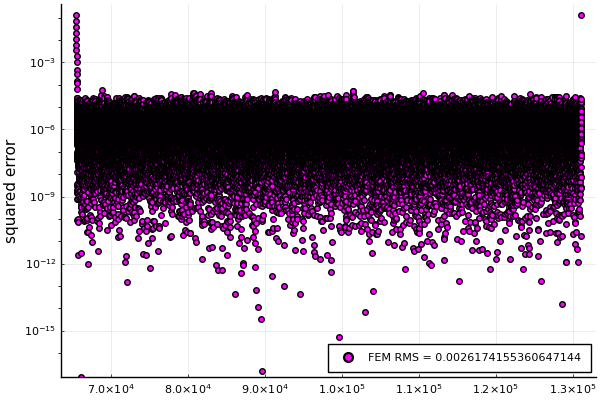

In [36]:
sqerror_FEM = (simulations_FEM[1][ts+1:T] - output[ts+1:T]).^2
RMS_FEM = sqrt(mean(sqerror_FEM))

scatter(ts:T, sqerror_FEM, label="FEM RMS = "*string(RMS_FEM), color="magenta", ylabel="squared error", yscale=:log10)

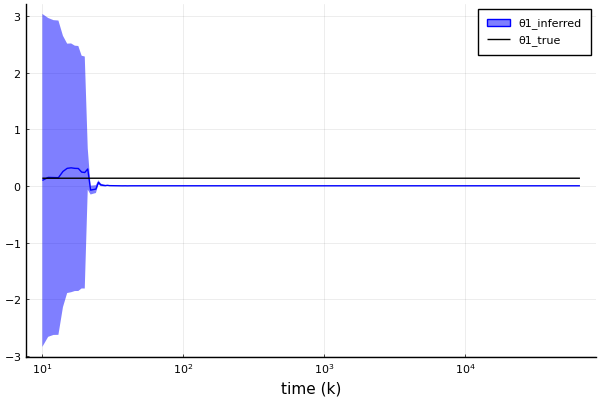

In [37]:
plot(tt:ts, params_θ[1][:,1], ribbon=[sqrt.(params_θ[2][:,1,1]) sqrt.(params_θ[2][:,1,1])], color="blue", xlabel="time (k)", xscale=:log10, label="θ1_inferred")
plot!(tt:ts, θ_true[1]*ones(ts-tt+1,), color="black", label="θ1_true")

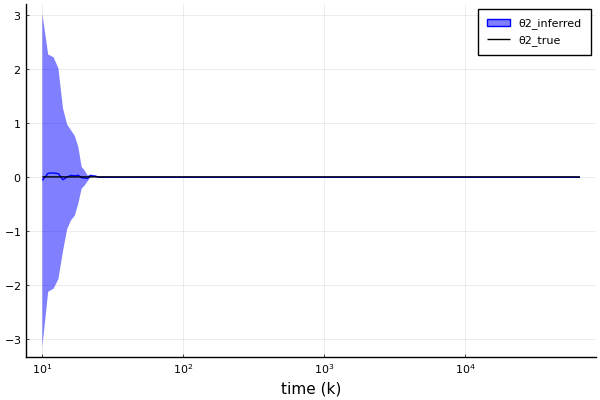

In [38]:
plot(tt:ts, params_θ[1][:,2], ribbon=[sqrt.(params_θ[2][:,2,2]) sqrt.(params_θ[2][:,2,2])], color="blue", xlabel="time (k)", xscale=:log10, label="θ2_inferred")
plot!(tt:ts, θ_true[2]*ones(ts-tt+1,), color="black", label="θ2_true")

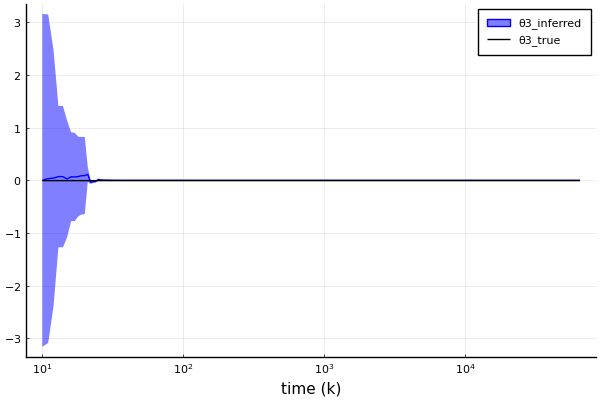

In [39]:
plot(tt:ts, params_θ[1][:,3], ribbon=[sqrt.(params_θ[2][:,3,3]) sqrt.(params_θ[2][:,3,3])], color="blue", xlabel="time (k)", xscale=:log10, label="θ3_inferred")
plot!(tt:ts, θ_true[3]*ones(ts-tt+1,), color="black", label="θ3_true")

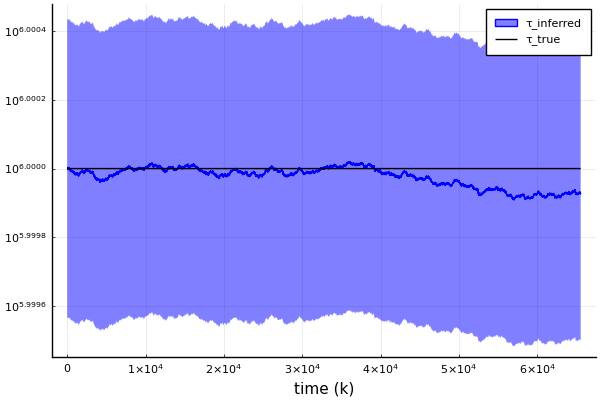

In [40]:
mτ = params_τ[1] ./ params_τ[2]
sτ = sqrt.(params_τ[1] ./ params_τ[2].^2)

plot(tt:ts, mτ, ribbon=[sτ sτ], color="blue", xlabel="time (k)", label="τ_inferred", yscale=:log10)
plot!(tt:ts, τ_true*ones(ts-tt+1,), color="black", label="τ_true")

## Baseline: RLS

Recursive least-squares estimator ([wiki](https://en.wikipedia.org/wiki/Recursive_least_squares_filter#Recursive_algorithm)).

In [41]:
# Parameters
λ = 1.00
P = λ.*Matrix{Float64}(I,N_m,N_m)
w_k = zeros(N_m,)
w = zeros(T,N_m)

# Preallocate prediction array
predictions_RLS = zeros(T,)
residuals = zeros(T,)

for k in tt:ts

    # Update data vector
    ϕx = ϕ([output[k-1:-1:k-M1_m]; input[k:-1:k-M2_m]; residuals[k-1:-1:k-M3_m]])

    # Update weights
    α = output[k] - w_k'*ϕx 
    g = P*ϕx*inv(λ + ϕx'*P*ϕx)
    P = inv(λ)*P - g*ϕx'*inv(λ)*P
    w_k = w_k + α*g

    # Prediction
    predictions_RLS[k] = w_k'*ϕx
    residuals[k] = output[k] - predictions_RLS[k]
    
    # Track weights
    w[k,:] = w_k

end

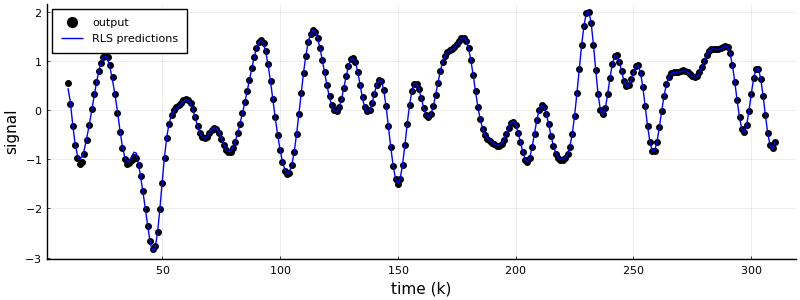

In [42]:
if (ts-tt) > 300
    scatter(tt:tt+300, output[tt:tt+300], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
    plot!(tt:tt+300, predictions_RLS[tt:tt+300], color="blue", label="RLS predictions")
else
    scatter(tt:ts, output[tt:ts], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
    plot!(tt:ts, predictions_RLS[tt:ts], color="blue", label="RLS predictions")
end

In [78]:
# Prepare array
simulations_RLS = zeros(T,)
simulations_RLS[1:ts] = output[1:ts]

# Simulation
for k in ts:T
    
    # Update data vector
    ϕx = ϕ([simulations_RLS[k-1:-1:k-M1_m]; input[k:-1:k-M2_m]; zeros(M3_m,)])
    
    # Prediction
    simulations_RLS[k] = w_k'*ϕx
    
end

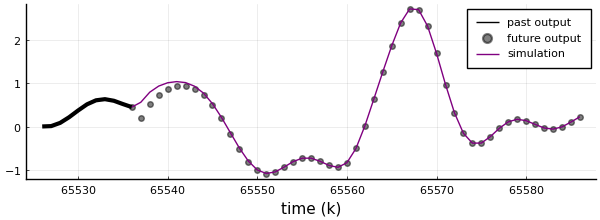

In [79]:
past = 10
p220 = plot(ts-past:ts, output[ts-past:ts], color="black", linewidth=3, label="past output", xlabel="time (k)", ylabel="", size=(600,220))

viz_t = 50
if T-ts > viz_t
    scatter!(ts:ts+viz_t, output[ts:ts+viz_t], color="black", alpha=0.5, label="future output", xlabel="time (k)")
    plot!(ts:ts+viz_t, simulations_RLS[ts:ts+viz_t], color="purple", label="simulation")
else
    scatter!(ts:T, output[ts:T], color="black", label="future output", xlabel="time (k)")
    plot!(ts:T, simulations_RLS[ts:T], color="purple", label="simulation")
end

In [80]:
savefig(p220, "figures/NARMAX-simulation_deg"*string(deg_m)*"_order"*string(M_m)*"_RLS_simfirst"*string(viz_t)*".png")

In [46]:
# # Full signal
# scatter(tt:T, output[tt:T], color="black", markersize=3, label="output", xlabel="time (k)", ylabel="signal", size=(800,300))
# plot!(tt:ts, predictions_RLS[tt:ts], color="blue", label="predictions")
# plot!(ts:T, simulations_RLS[ts:T], color="purple", label="simulation")

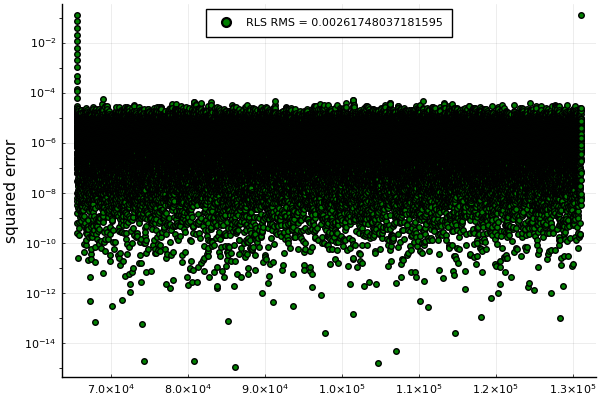

In [47]:
sqerror_RLS = (simulations_RLS[ts+1:T] - output[ts+1:T]).^2
RMS_RLS = sqrt(mean(sqerror_RLS))

scatter(ts:T, sqerror_RLS, label="RLS RMS = "*string(RMS_RLS), color="green", ylabel="squared error", yscale=:log10)

## Comparison

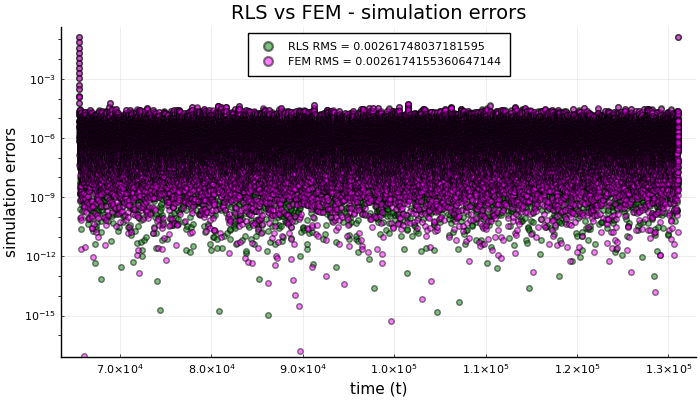

In [48]:
# Comparing simulation errors between PEM and FEM
scatter(ts:T, 
        sqerror_RLS, 
        color="green", 
        alpha=0.5,
        markersize=4, 
        size=(700,400), 
        yscale=:log10,
        xlabel="time (t)", 
        ylabel="simulation errors",
        label="RLS RMS = "*string(RMS_RLS))
scatter!(ts:T, 
         sqerror_FEM, 
         color="magenta", 
         alpha=0.5,
         markersize=4,
         labels="FEM RMS = "*string(RMS_FEM),
         title="RLS vs FEM - simulation errors")

In [49]:
savefig("figures/NARMAX-errors_deg"*string(deg_m)*"_order"*string(M_m)*".png")

In [50]:
prop_beaten = mean(sqerror_FEM .< sqerror_RLS)
println("Proportion FEM < RLS = "*string(round(prop_beaten*100))*"%")

Proportion FEM < RLS = 51.0%


Now re-check RMS without first 100 simulation samples.

In [51]:
sqerror_FEM = (simulations_FEM[1][ts+100:T] - output[ts+100:T]).^2
sqerror_RLS = (simulations_RLS[ts+100:T] - output[ts+100:T]).^2

RMS_FEM = sqrt(mean(sqerror_FEM))
RMS_RLS = sqrt(mean(sqerror_RLS))

println("RMS FEM = "*string(RMS_FEM))
println("RMS RLS = "*string(RMS_RLS))
println("RMS KLS = "*string(RMS_KLS))

RMS FEM = 0.0015662488158217837
RMS RLS = 0.0015682212563725368
RMS KLS = 0.001567107310452663


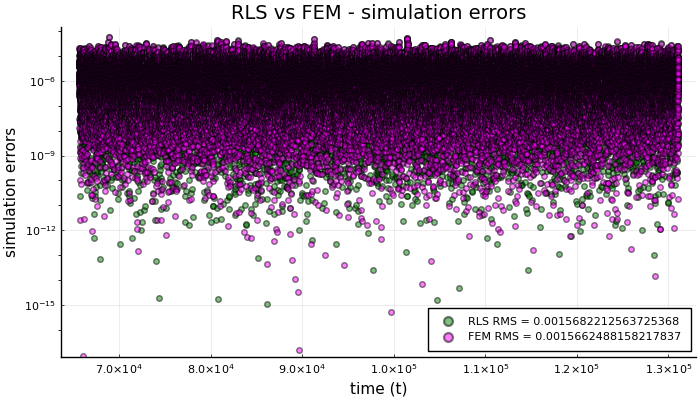

In [52]:
# Comparing simulation errors between PEM and FEM
scatter(ts+100:T, 
        sqerror_RLS, 
        color="green", 
        alpha=0.5,
        markersize=4, 
        size=(700,400), 
        yscale=:log10,
        xlabel="time (t)", 
        ylabel="simulation errors",
        label="RLS RMS = "*string(RMS_RLS))
scatter!(ts+100:T, 
         sqerror_FEM, 
         color="magenta", 
         alpha=0.5,
         markersize=4,
         labels="FEM RMS = "*string(RMS_FEM),
         title="RLS vs FEM - simulation errors")